[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorial_notebooks/6_classification_tasks.ipynb) 

# Tutorial 6 - Classification for Credit Risk Prediction
In this demo notebook, we will revisit our lecture on classification models. To that end, we consider the logistic regression model and study how it allows us to approach a probability-to-default prediction task. The notebook comprises ready-to-use demo codes and small programming tasks. 

# Preliminaries
Before moving on, let's import some of our standard library so that we have them ready when we need them.


In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## The HMEQ data set
We continue using the "Home Equity" data set (HMEQ), which was introduced in your [last session](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb).
To keep this notebook self-contained, we re-introduce the set of features below: 

- BAD: the target variable, 1=default; 0=non-default 
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

## Pandas reloaded
You have already seen the Pandas library in action. We assume you have familiarized yourself with the demos and exercises of [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb). Let us briefly recap a few Pandas function to eyeball the data: 

- Preview the first rows of a DataFrame: `df.head()`
- Get a structural summary of a DataFrame: `df.info()`
- Get summary statistics of numerical columns: `df.describe()`

Below, we load the HMEQ data set from our GitHub repository and store a copy in the variable `df` (for DataFrame). Apply the above function to the variable to  re-familiarize yourself with the dataset. 

In [4]:
# Load the data directly from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq.csv'
df = pd.read_csv(data_url)


In [5]:
# Space to eyeball and explore the dataset
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


## Preparing the data for analysis
 [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb) was all about exploratory data analysis and data preparation. The HMEQ datasets exhibits some quality problems  and requires some preparation. More specifically, [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb) covered:
 - Handling missing values
 - Truncating outliers
 - Encoding categorical variables
 - Feature scaling

We will not repeat everything here. Simply go back to the previous tutorial if unsure about any of the above preparation steps. Given that we will keep using the HMEQ dataset in future tutorials, we put all Python codes to convert from the raw version of the data to a preprocessed "ready-for-analysis" in the below function `prepare_hmeq_data`. The code may look somewhat involved, but you should be able to follow most of it based on what you have learned so far. Also, it is fine to skip the details for now and simply use the function as a black box. Just make sure to execute the code cell so that the function is defined in your notebook environment.

In [6]:
import pandas as pd
from typing import Tuple
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def prepare_hmeq_data(df: pd.DataFrame, missing_dummy=True, outlier_factor: float = 0, scale_features: bool = True, verbose=0) -> Tuple[pd.DataFrame, pd.Series]:
    """ Prepare the HMEQ data for analysis.
        Missing values will be imputed using the median (numerical features) or the mode (categorical features).
        Optionally, a dummy variable can be added for each feature indicating for which cases, in that feature, imputation was carried out. 
        Other data preparation steps, including outlier truncation (using the IQR method), feature scaling (z-transformation), and dicretization
        can be configured via arguments.

    Parameters
    ----------  
    df : pd.DataFrame
        Raw HMEQ data as a Pandas DataFrame.
    missing_dummy : bool, optional
        Whether to add a dummy variable indicating missingness for DEBTINC. Default is True.
    outlier_factor : float, optional
        Factor to determine the extent of outlier truncation using the IQR method. Default is 0 (no truncation). 
        If set to a positive number, outliers are truncated at Q1 - outlier_factor*IQR and Q3 + outlier_factor*IQR.
    scale_features : bool, optional
        Whether to scale numerical features using z-transformation. Default is True.
    verbose : int, optional
        Verbosity level for logging. Default is 0 (no logging).

    Returns
    -------
    X : pd.DataFrame
        Prepared feature matrix.
    y : pd.Series
        Target variable (BAD).
    """
    
    X = df.copy()  # Create a copy of the original data frame
    y = X.pop('BAD')  # Separate the target variable
    ####################################################################
    # Type conversion
    #-------------------------------------------------------------------
    df['BAD'] = df['BAD'].astype('bool')  # The target variable has only two states so that we can store it as a boolean
    df['REASON'] = df['REASON'].astype('category')  # Code categories properly 
    df['JOB'] = df['JOB'].astype('category')
    df['LOAN'] = df['LOAN'].astype('float')  # Ensure all numerical features use data type float (for indexing) 

    cat_features = df.select_dtypes(include=['category']).columns  # Get an index of the categorical columns
    num_features = df.select_dtypes(include=['float']).columns  # Get an index of the numerical columns

    ####################################################################
    # Missing value imputation
    #-------------------------------------------------------------------
    for col in X.columns:
        # Check if there are missing values in this column
        if X[col].isna().any():
            # If requested, add dummy BEFORE imputation to capture original missingness
            if missing_dummy==True:
                dummy_col_name = f"{col}_missing"
                X[dummy_col_name] = X[col].isna()
                if verbose>0: print(f"Added missingness dummy for column {col} as {dummy_col_name}")

            # Handle floats: fill with median
            if col in num_features:
                median_value = X[col].median()
                X[col] = X[col].fillna(median_value)
                if verbose>0: print(f"Filled missing values in numerical column {col} with median value {median_value}")

            # Handle categoricals/objects: fill with mode
            elif col in cat_features:
                # mode() returns a Series; take the first mode if it exists
                modes = X[col].mode(dropna=True)
                if len(modes) > 0:
                    mode_value = modes.iloc[0]
                    X[col] = X[col].fillna(mode_value)
                    if verbose>0: print(f"Filled missing values in categorical column {col} with mode value {mode_value}")
                else:
                    raise Exception(f"No mode found for column {col} during imputation. Leaving this column untouched.")
                continue
            else:
                raise Exception(f"Column")

    # Verify that there are no missing values left
    check = X.isna().sum().sum()
    if check > 0:
        raise Exception(f"We still observe {check} missing values in the data.")
    ####################################################################
    # Feature engineering: 
    # Domain knowledge suggests that the features DELINQcat and DEROG are important predictors of loan default.
    # However, their distribution is highly skewed, with many zeros and few high values. 
    # To aid modeling, we add a dummy feature distinguishing cases where these features are zero versus non-zero 
    #-------------------------------------------------------------------
    X['DELINQ_nz'] = pd.cut(X['DELINQ'], bins=[-1, 0, float('inf')], labels=[0, 1])
    X['DEROG_nz'] = pd.cut(X['DEROG'], bins=[-1, 0, float('inf')], labels=[0, 1])

    ####################################################################
    # Truncate outliers among numerical features
    #-------------------------------------------------------------------
    if outlier_factor > 0:
        for col in num_features:
            q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
            min_x, max_x = X[col].min(), X[col].max()
            iqr = q3 - q1
            lower_bound = np.max([q1 - outlier_factor * iqr, min_x])
            upper_bound = np.min([q3 + outlier_factor * iqr, max_x])
            X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)
            if lower_bound > min_x or upper_bound < max_x:
                if verbose>0: print(f"Truncated outliers in column {col} to range [{lower_bound}, {upper_bound}]")

    #-------------------------------------------------------------------
    # Scale numerical features using the z-transformation (if requested)
    #-------------------------------------------------------------------
    if scale_features == True:
        scaler = StandardScaler()
        X[num_features] = scaler.fit_transform(X[num_features])
    #-------------------------------------------------------------------
    # Dummy encode categorical features
    #-------------------------------------------------------------------
    dummy_codes = pd.get_dummies(X[cat_features], drop_first=True)  # obtain dummy codes
    X.drop(cat_features, axis=1, inplace=True)    # remove original categorical features
    X = pd.concat([X, dummy_codes], axis=1)  # add dummy codes back to feature matrix     
    return X, y


In [7]:
# Preprocess the data
X, y = prepare_hmeq_data(df)
# Preview the processed feature matrix
X.head(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,...,CLNO_missing,DEBTINC_missing,DELINQ_nz,DEROG_nz,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.562299,-1.107920,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963,...,False,True,0,0,True,False,True,False,False,False
1,-1.544453,-0.069286,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963,...,False,True,1,0,True,False,True,False,False,False
2,-1.526606,-1.398407,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963,...,False,True,0,0,True,False,True,False,False,False
3,-1.526606,-0.187596,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963,...,True,True,0,0,False,False,True,False,False,False


# Binary classification for PD modeling
Having prepared our data, we can proceed with predictive modeling. The lecture introduced the general classification setup as an extension of regression. You will remember the many plots we came across when discussing regression. We also saw some analog plots for classification problems in the lecture. One of them was a 2d scatter plot displaying the bi-variate relationship between selected features and the binary target variable. 
<p align="left">
  <img src="https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/2d_classification_problem.png" alt="2D classification problem" width="640" />
</p>
Let us recreate such a plot for the HMEQ data. We arbitrarily select `LOAN` and `VALUE` as our two features of interest. Interact with the code to create the scatterplot for different pairs of variables. Also try to interpret the plot. What does it tell you about the classification problem? 

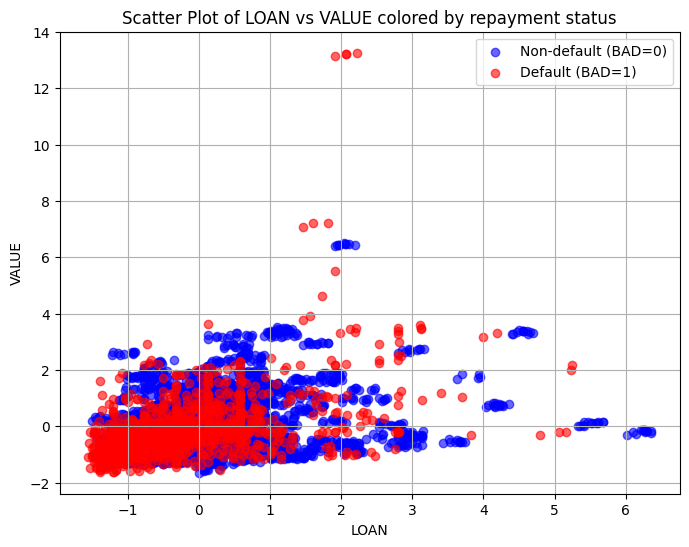

In [9]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
# Scatterplot of our classification problem
x1 = 'LOAN'  # select first feature of your choice
x2 = 'VALUE'  # select second feature of your choice

# Create a scatter plot for LOAN vs VALUE, colored by BAD
plt.figure(figsize=(8,6))
plt.scatter(X[x1][y==0], X[x2][y==0], color='blue', label='Non-default (BAD=0)', alpha=0.6)
plt.scatter(X[x1][y==1], X[x2][y==1], color='red', label='Default (BAD=1)', alpha=0.6)
plt.xlabel(x1)
plt.ylabel(x2)
plt.title(f'Scatter Plot of {x1} vs {x2} colored by repayment status')
plt.legend()
plt.grid()
plt.show()


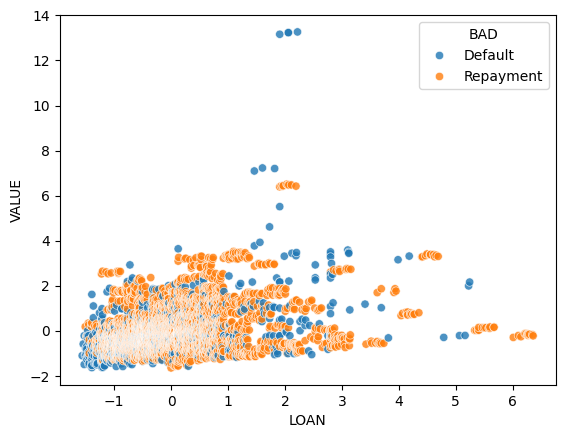

In [10]:
# Note that the seaborn library could be used instead, which is often simpler to create standard visualizations.
# Here is an example needed only one line of code:
sns.scatterplot(data=X, x=x1, y=x2, hue=y.map({0: "Repayment", 1: "Default"}), alpha=0.8);


## Logistic regression
Time to estimate our first model. We will use logistic regression. Think of it as an extension of linear regression for cases in which we work with a binary target variable. Recall the formula of the logistic function:

$$ \frac{1}{1+exp(-\eta)} $$
where
$$ \eta = b + w_1 x_1 + w_2 x_2 + ... + w_p x_p $$

Below, we use the sklearn library to estimate a logistic regression model on the prepared HMEQ data.


In [11]:
# Train a logistic regression-based model for classification
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X, y)  # we define a random_state to ensure that we get the same results when re-running this cell multiple times
print(model)

LogisticRegression()


Note that the `sklearn` implementation does not provide an informative summary, as we might expect based on our experiences with linear regression. The sklearn library is designed for prediction. That is why much of the functionality on regression diagnostics, statistical tests, and so on, is missing. You can check out the library `statsmodels` for an implementation of logistic regression, and other [statistical models](https://www.statsmodels.org/stable/index.html) that better supports explanatory modeling. We focus on prediction.


Let's first demonstrate how to use our logistic regression for prediction. All sklearn models provide a function `model.predict()`, which requires, as argument, a matrix of feature values. Equipped with this information let's try to create our standard input to forecast model evaluation: a table with actual values of the target variable $Y$ and model-based forecasts $ \hat{Y} $.

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/y_yhat.png" alt="Comparing forecasts to actuals" width="170" />
</p>


In [13]:
# To be completed in class 
# 1. Use the model to predict the class labels for our data
yhat = model.predict(X)

# 2. Create a DataFrame to compate Actual (Y) vs Forecast (Y_hat)
results = pd.DataFrame({
    'Y': y,
    'Y_hat': yhat
})

#3. Display the first 5 rows to eyeball the results
results.head()

,Y,Y_hat
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0


# Data organization
It is good practice to split labelled data into training and test partitions, using the training set for model estimation and the test set of evaluation. 


<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/holdout_method.png" alt="Holdout method" width="640" />
</p>

The key sklearn function to support this step is `train_test_split()`. Of course, sklearn also provides support for cross-validation, which we will explore in a later tutorial. For now, a simple train-test split is all we need to illustrate proper evaluation. The next code cell illustrates the use of the function and it is commonly used to create four variables storing, respectively, the feature matrix of the training and test partitions and the corresponding target labels.  


In [19]:

from sklearn.model_selection import train_test_split
random_seed = 312  # for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)


## Mini-Task:
Estimate a new logit model using only the training data. Then, compute test set predictions. Overwrite our current variables `model` and `yhat` to store the new model and the test set predictions, respectively.

In [21]:
# Code for the mini task

model = LogisticRegression().fit(X_train, y_train)
yhat = model.predict(X_test)

# Create a DataFrame to compate Actual (Y) vs Forecast (Y_hat)
results = pd.DataFrame({
    'Y': y_test,
    'Y_hat': yhat
})

results.head(8)


,Y,Y_hat
3103,0,0
5426,0,0
40,1,1
4641,0,0
5200,0,0
584,0,0
3753,0,0
5437,0,0


### Exercises 1 Evaluating predictions
Now that we set up our model evaluation dataset, your first exercise is to compute some of the standard classification performance metrics introduced in the lecture. In particular, compute the following metrics based on the true and predicted labels stored in the variables `y` and `yhat`, respectively:
- Accuracy $\frac{TP + TN}{TP + TN + FP + FN}$
- Precision $\frac{TP}{TP + FP}$
- Recall $\frac{TP}{TP + FN}$
- F1-score  $\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$

Of course, we could calculate these metrics manually using basic Python commands. However, sklearn provides ready-to-use functions, which makes evaluation much easier. The next coding cell already imports the relevant functions.  

Sklearn also facilitates the computation of a confusion matrix and the ROC curve, which are useful tools to visualize classification performance. Explore the classes `ConfusionMatrixDisplay` and `RocCurveDisplay`, which we import below. Write code to create a plot of the confusion matrix and the ROC curve respectively.

In [22]:
# Codes for Exercise 1: Standard evaluation metrics for classification models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# Calculate the metrics using y_test (Actuals) and yhat (Predictions)
acc = accuracy_score(y_test, yhat)
prec = precision_score(y_test, yhat)
rec = recall_score(y_test, yhat)
f1 = f1_score(y_test, yhat)

# Print the results
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")



Accuracy:  0.8881
Precision: 0.7918
Recall:    0.5966
F1-score:  0.6805


Confusion Matrix:


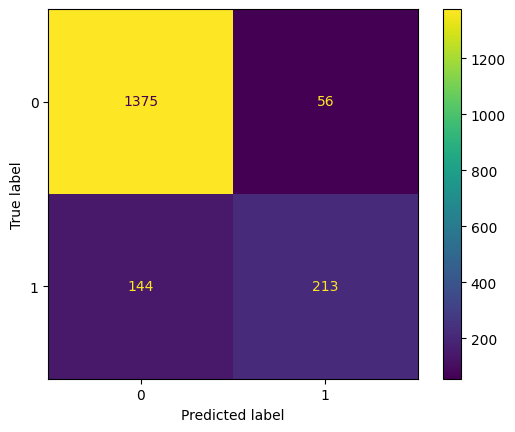

ROC Curve:


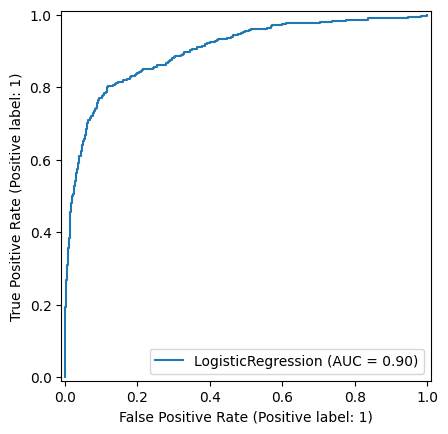

In [23]:
# Codes for Exercise 1 continued: Visualization of classification model performance
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# 1. Plot Confusion Matrix
# We can use from_predictions since we have the hard labels (0/1) in yhat
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, yhat)
plt.show()

# 2. Plot ROC Curve
# We use from_estimator here because ROC curves require probabilities, not just 0/1 predictions.
# This function asks the model for probabilities automatically.
print("ROC Curve:")
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

1. ROC Curve:


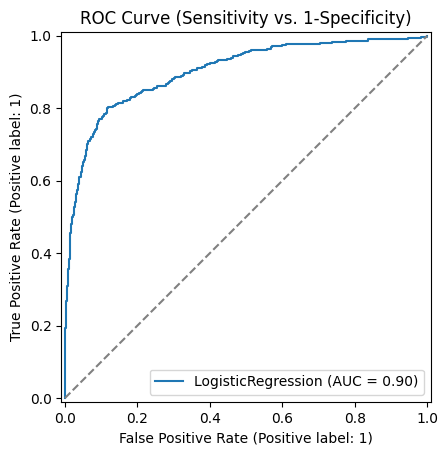

------------------------------------------------------------
2. Formula Breakdown (The Axes of the ROC Plot):
------------------------------------------------------------
Y-AXIS: SENSITIVITY (Recall)
Formula: TP / (TP + FN)
       = 213 / (213 + 144)
       = 213 / 357
       = 0.5966
------------------------------
STEP:   SPECIFICITY (True Negative Rate)
Formula: TN / (TN + FP)
       = 1375 / (1375 + 56)
       = 1375 / 1431
       = 0.9609
------------------------------
X-AXIS: 1 - SPECIFICITY (False Positive Rate)
Formula: 1 - Specificity
       = 1 - 0.9609
       = 0.0391
------------------------------------------------------------
DISCUSSION:
This specific point (0.04, 0.60) represents the performance
of your model at the default decision threshold (0.5).
The blue line represents ALL possible thresholds.


In [30]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# 1. Plot the ROC Curve
# The ROC curve plots Sensitivity (Y) against 1-Specificity (X)
print("1. ROC Curve:")
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve (Sensitivity vs. 1-Specificity)")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess') # Add diagonal line
plt.show()

# 2. Extract the raw numbers from the Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()

# 3. Print the detailed formula breakdown
print("-" * 60)
print("2. Formula Breakdown (The Axes of the ROC Plot):")
print("-" * 60)

# A) Sensitivity (True Positive Rate) -> The Y-Axis
sensitivity = tp / (tp + fn)
print(f"Y-AXIS: SENSITIVITY (Recall)")
print(f"Formula: TP / (TP + FN)")
print(f"       = {tp} / ({tp} + {fn})")
print(f"       = {tp} / {tp + fn}")
print(f"       = {sensitivity:.4f}")
print("-" * 30)

# B) Specificity (True Negative Rate) -> Intermediate Step
specificity = tn / (tn + fp)
print(f"STEP:   SPECIFICITY (True Negative Rate)")
print(f"Formula: TN / (TN + FP)")
print(f"       = {tn} / ({tn} + {fp})")
print(f"       = {tn} / {tn + fp}")
print(f"       = {specificity:.4f}")
print("-" * 30)

# C) 1 - Specificity (False Positive Rate) -> The X-Axis
fpr = 1 - specificity
print(f"X-AXIS: 1 - SPECIFICITY (False Positive Rate)")
print(f"Formula: 1 - Specificity")
print(f"       = 1 - {specificity:.4f}")
print(f"       = {fpr:.4f}")

print("-" * 60)
print("DISCUSSION:")
print(f"This specific point ({fpr:.2f}, {sensitivity:.2f}) represents the performance")
print("of your model at the default decision threshold (0.5).")
print("The blue line represents ALL possible thresholds.")

## Discussion point: what is wrong with the ROC curve?


Precision-Recall Curve:


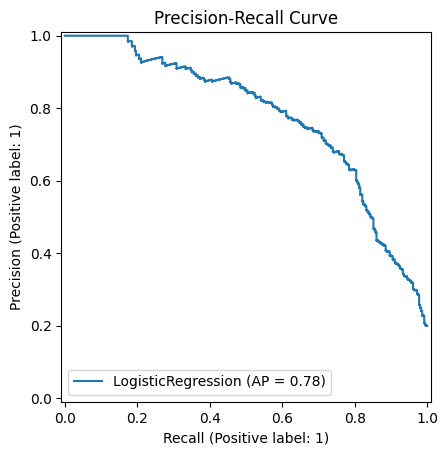

Percentage of Defaults in Test Data:
BAD
0    0.800336
1    0.199664
Name: proportion, dtype: float64


In [24]:
# Discussion codes

from sklearn.metrics import PrecisionRecallDisplay

# The ROC curve can be misleading when classes are imbalanced (few defaults, many repayments).
# The Precision-Recall curve is often a better diagnostic tool in these cases.

print("Precision-Recall Curve:")
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

# Let's also check the actual imbalance in our test set
print("Percentage of Defaults in Test Data:")
print(y_test.value_counts(normalize=True))

1. Precision-Recall Curve:


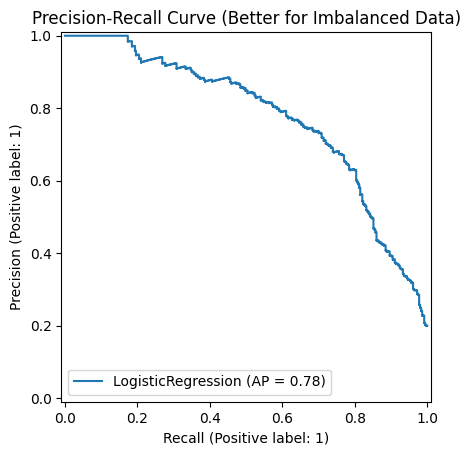

--------------------------------------------------
2. Formula Breakdown (How the scores are calculated):
--------------------------------------------------
PRECISION = TP / (TP + FP)
          = 213 / (213 + 56)
          = 213 / 269
          = 0.7918
------------------------------
RECALL    = TP / (TP + FN)
          = 213 / (213 + 144)
          = 213 / 357
          = 0.5966
--------------------------------------------------
DISCUSSION:
The ROC curve looks 'perfect' because it includes True Negatives (repayments),
which are very easy to predict. The Precision-Recall curve highlights that
when we try to find all defaults (Recall), our precision drops.


In [26]:
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix

# 1. Plot the Precision-Recall Curve
# The PR curve is preferred over ROC for imbalanced datasets (few defaults)
print("1. Precision-Recall Curve:")
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title("Precision-Recall Curve (Better for Imbalanced Data)")
plt.show()

# 2. Extract the raw numbers from the Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()

# 3. Print the detailed formula breakdown
print("-" * 50)
print("2. Formula Breakdown (How the scores are calculated):")
print("-" * 50)

# Precision Formula
precision_calc = tp / (tp + fp)
print(f"PRECISION = TP / (TP + FP)")
print(f"          = {tp} / ({tp} + {fp})")
print(f"          = {tp} / {tp + fp}")
print(f"          = {precision_calc:.4f}")
print("-" * 30)

# Recall Formula
recall_calc = tp / (tp + fn)
print(f"RECALL    = TP / (TP + FN)")
print(f"          = {tp} / ({tp} + {fn})")
print(f"          = {tp} / {tp + fn}")
print(f"          = {recall_calc:.4f}")
print("-" * 50)

# Explanation of the Trade-off
print("DISCUSSION:")
print("The ROC curve looks 'perfect' because it includes True Negatives (repayments),")
print("which are very easy to predict. The Precision-Recall curve highlights that")
print(f"when we try to find all defaults (Recall), our precision drops.")

# Visualizing the logistic regression
We conclude the notebook with with a visualization of the logistic regression model. To abstract from the complexities of real-word data like our HMEQ data set, we will use sklearn functions to create synthetic data for classification with a clear signal. We will also restrict ourselves to two features (i.e., 2D) to facilitate visualization of the data and the final logistic model. 

The function for visualizing the data and logistic regression model called `plot_logit_decision_surface()` is defined below. The code cell may look somewhat involved, but you should be able to follow most of it based on what you have learned so far. Also, it is fine to skip the details of the implementation. However, make sure to execute the next code cell so that the function is defined in your notebook environment. The following code cell will then put everything together, first creating synthetic data and then calling the visualization function.

In [27]:
def plot_logit_decision_surface(Xtr, Xts, ytr, yts):
    """
    Visualization of logistic regression in 2D.
    Plots probability surface, training data (faded/small), and test data (dominant).

    Parameters
    ----------
    Xtr : np.ndarray
        Training feature matrix.
    Xts : np.ndarray
        Test feature matrix.
    ytr : np.ndarray            
        Training labels.
    yts : np.ndarray
        Test labels.
    Returns
    -------
    None
        The function displays a plot and does not return any value.        
    """

    # Fit model
    lr = LogisticRegression().fit(Xtr, ytr)

    # Use both train + test to define bounds
    Xall = np.vstack([Xtr, Xts])
    min_x, min_y = Xall.min(axis=0)
    max_x, max_y = Xall.max(axis=0)

    eps = 0.5     # padding around data
    res = 300     # grid resolution per axis

    # Grid for probability surface
    xs = np.linspace(min_x - eps, max_x + eps, res)
    ys = np.linspace(min_y - eps, max_y + eps, res)
    xx, yy = np.meshgrid(xs, ys)

    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = lr.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    # Probability contour
    levels = np.linspace(0, 1, 26)
    contour = ax.contourf(xx, yy, probs, levels=levels,
                          cmap="RdBu", vmin=0, vmax=1)
    cbar = fig.colorbar(contour)
    cbar.set_label(r"$\hat{p}(y=1|X)$")
    cbar.set_ticks([0, .25, .5, .75, 1])

    # ------------------------
    # TRAINING DATA (small, transparent)
    # ------------------------
    ax.scatter(
        Xtr[:, 0], Xtr[:, 1], 
        c=ytr, 
        cmap="RdBu",
        vmin=0, vmax=1,
        s=30,                    # smaller
        alpha=0.5,               # transparent so test dominates
        marker="o",              # filled circle
        edgecolor="white"
    )

    # ------------------------
    # TEST DATA (larger, highlighted)
    # ------------------------
    ax.scatter(
        Xts[:, 0], Xts[:, 1],
        c=yts,
        cmap="RdBu",
        vmin=0, vmax=1,
        s=50,                    # larger
        marker="o",              # triangle to distinguish
        edgecolor="white",
        linewidth=1
    )

    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    ax.set_xlim(min_x - eps, max_x + eps)
    ax.set_ylim(min_y - eps, max_y + eps)
    plt.show()

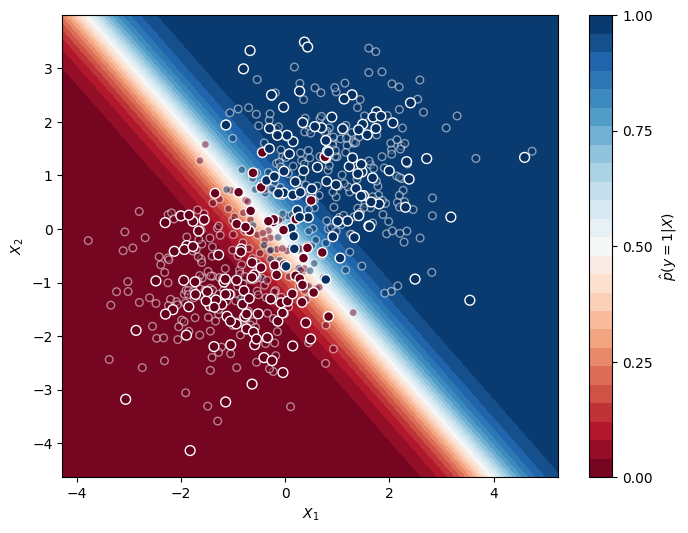

In [28]:
from sklearn.datasets import make_blobs

# generate linearly separable data with 2 classes
Xsyn, Ysyn = make_blobs(n_samples=600,
                  n_features=2,
                  centers=[[-1, -1], [1, 1]],
                  cluster_std=1, 
                  random_state=random_seed)


# Data partitioning
Xtr, Xts, ytr, yts = train_test_split(Xsyn, Ysyn, test_size=0.3, random_state=random_seed)
# Calling our plotting function
plot_logit_decision_surface(Xtr, Xts, ytr, yts)

# Well done! This was another comprehensive set of exercises.